# Creating a Kaggle Workflow
An exercise to learn how to create a data science workflow for Kaggle. Workflows provide a framework to make iterating on ideas quicker and easier. Here we will create a workflow for competing in a Kaggle competition (Titanic Survivors) by using a pipeline of functions to make iterative submissions possible.

## Exploring the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import the train and holdout data as pandas dataframes
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

# Display the first 10 rows of the holdout data
holdout.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


In [3]:
# Load pre-written functions for processing the data
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
# Create a single function that applies all of the pre-written data processing functions
# The dummy function requires looping through the selected columns

def process_data(df):
    process_missing(df)
    process_age(df)
    process_fare(df)
    process_titles(df)
    process_cabin(df)
    
    # Loop through columns to create dummies where applicable
    dummy_columns = ['Age_categories',
                    'Fare_categories',
                    'Title',
                    'Cabin_type',
                    'Sex']
    for col in dummy_columns:
        df = create_dummies(df,col)
        
    return df

In [5]:
# Apply the process data function to the train and holdout dataframes

train = process_data(train)
holdout = process_data(holdout)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


In [6]:
# Explore data about family members (siblings and parent/child on board)

fam_cols = ['SibSp', 'Parch', 'Survived']
explore_fam = train[fam_cols].copy()
explore_fam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


In [7]:
# Set a criteria for survival rate by finding the mean

train['Survived'].mean()

0.3838383838383838

In [8]:
# Create a new column that combines the total family members on board
explore_fam['n_family'] = explore_fam['SibSp'] + explore_fam['Parch']

Text(0.5, 1.0, 'Histogram of Family Member Distribution')

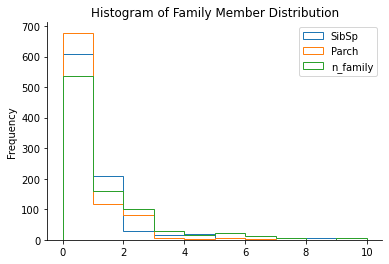

In [9]:
# Plot a histogram of distribution (all columns besides Survival)

ax = explore_fam.drop('Survived', axis=1).plot.hist(histtype='step')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Histogram of Family Member Distribution')

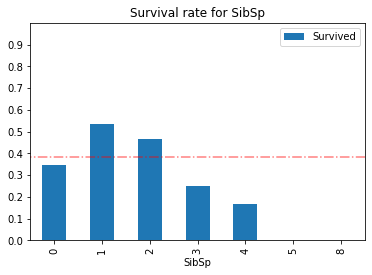

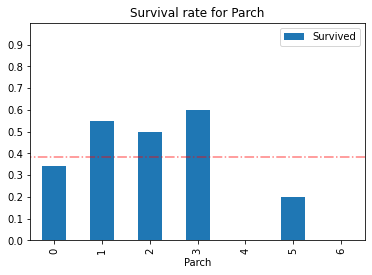

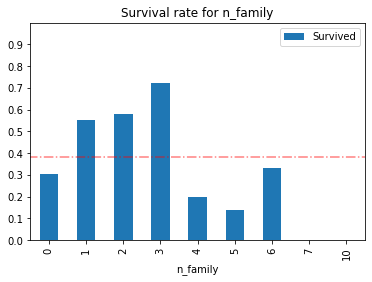

In [10]:
# Plot the survival rate of each value in these columns

for col in explore_fam.columns.drop('Survived'):
    pivot = explore_fam.pivot_table(index=col, values='Survived')
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.hlines(y=0.3838, xmin=-1, xmax=10, 
               alpha = 0.5, color ='red', linestyles='dashdot')
    plt.title('Survival rate for '+col)

### Conclusions on Family Size
We found that passengers with one to three family members had a higher survival rate than no family. There is a dropoff after three family members but the distribution is very low at those numbers (to not be significant). 

Result: Add a column for passengers without family.

In [11]:
# Adding a column to both dataframes to capture passengers without family
train['isalone'] = (train['SibSp'] + train['Parch']) == 0
holdout['isalone'] = (holdout['SibSp'] + holdout['Parch']) == 0

# Convert new column to integer
train['isalone'] = train['isalone'].astype(int)
holdout['isalone'] = holdout['isalone'].astype(int)

# Check the result
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,1,0,1,1


## Feature Selection
Find the best performing features using recursive feature elimination.

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [13]:
# Create a function that performs recursive feature elimination on a dataframe and prints list of the best columns

def select_features(df):
    # Remove columns that are not numeric or contain null values
    data = df.select_dtypes(exclude = ['category','object']).dropna()
    
    # Split data into features and target
    all_X = data[data.columns.drop(['PassengerId', 'Survived'])]
    all_y = data['Survived']
    
    # Use Random Forest and recursive feature elimination
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X, all_y)
    
    # Create a list of the best features
    selected_features = list(all_X.columns[selector.support_])
    print('Best Columns:', '\n', "\n{}\n".format(selected_features))
    
    return selected_features

selected_features = select_features(train)

Best Columns: 
 
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



## Model Selection
After finding the best performing features, find the best performing model.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Create a function to find the best model using Grid Search
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries containing the model name, estimator and a dictionary of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        # Print model name underlined
        print(model['name'])
        print('-'*len(model['name']))
        
        # Apply Grid Search to add best parameters, score, and model to the dictionary
        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_
        
        # Print the best score and parameters under the model name
        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,select_features)

Best Columns: 
 
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']

LogisticRegression
------------------
Best Score: 0.8204619225967541
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.7767041198501874
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8395505617977527
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf

### Model Selection Results
**Random Forest** with the following parameters received the highest accuracy score:
* 'criterion': 'gini', 
* 'max_depth': 10, 
* 'max_features': 'sqrt', 
* 'min_samples_leaf': 1, 
* 'min_samples_split': 5, 
* 'n_estimators': 6

## Kaggle Submission
Create a function for submitting a csv to Kaggle.

In [21]:
def save_submission_file(model, features, filename):
    #Use the model to predict the holdout feature columns
    prediction = model.predict(holdout[features])
    
    #Create a submission dataframe with the required columns
    submission = pd.DataFrame({
        'PassengerId': holdout['PassengerId'],
        'Survived': prediction
    })
    submission.to_csv(filename, index=False)
    return submission

In [22]:
#Use the result of the best model above to create a submission file
save_submission_file(result[2]['best_model'],selected_features,filename='submission_5.csv')

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
